# COMP5331 Group 6 Project: Resilient k-Clustering

In [6]:
from os import mkdir, makedirs
%load_ext autoreload
%autoreload 2

## Mount Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Comp 5331/"
%ls

## Preprocess datasets

In [1]:
from src.preprocess.process_uber import process_uber
ds_path = "dataset/uber/uber-raw-data-jun14.csv"
save_path = "dataset/uber/"
process_uber(ds_path, save_path)

11/08/2024, 13:20:35: creating graph
11/08/2024, 13:20:49: matching
11/08/2024, 13:20:54: finish


In [2]:
from src.preprocess.process_geo import process_geo
ds_names = ["Brightkite", "Gowalla"]
for ds_name in ds_names:
    print(f"Processing {ds_name} dataset")
    ds_path = f"dataset/snap_standford/{ds_name}_totalCheckins.txt"
    save_path = "dataset/snap_standford/"
    process_geo(ds_path, save_path, ds_name)

Processing Brightkite dataset
11/08/2024, 13:21:00: filtering
11/08/2024, 13:21:15: matching
11/08/2024, 13:21:15: finish
Processing Gowalla dataset
11/08/2024, 13:21:15: filtering
11/08/2024, 13:21:50: matching
11/08/2024, 13:21:50: finish


In [ ]:
from src.preprocess.process_birch import process_birch
ds_name = "birch1"
ds_path = f"dataset/birch/{ds_name}.txt"
save_path = "dataset/birch"
process_birch(ds_path, save_path, ds_name)

In [ ]:
from src.preprocess.process_high_dim import process_high_dim
dims = ['032', '064', '128']

for dim in dims:
    ds_name = "dim"+dim
    ds_path = f"/dataset/high_dim/{ds_name}.txt"
    save_path = "/dataset/high_dim"
    process_high_dim(ds_path, save_path, ds_name)

### Visualize the data

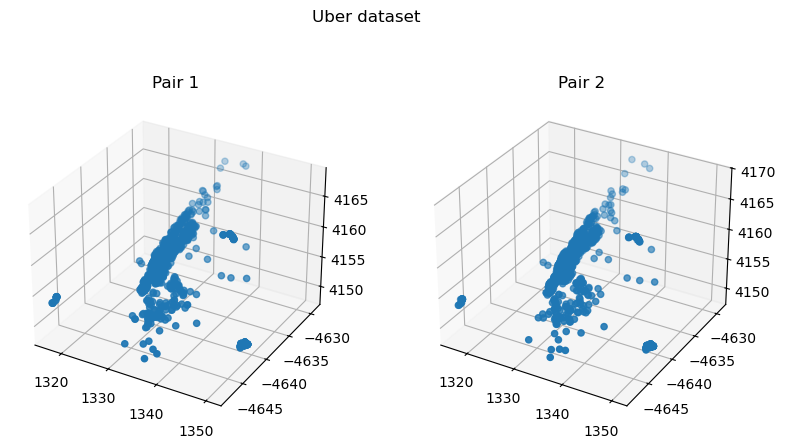

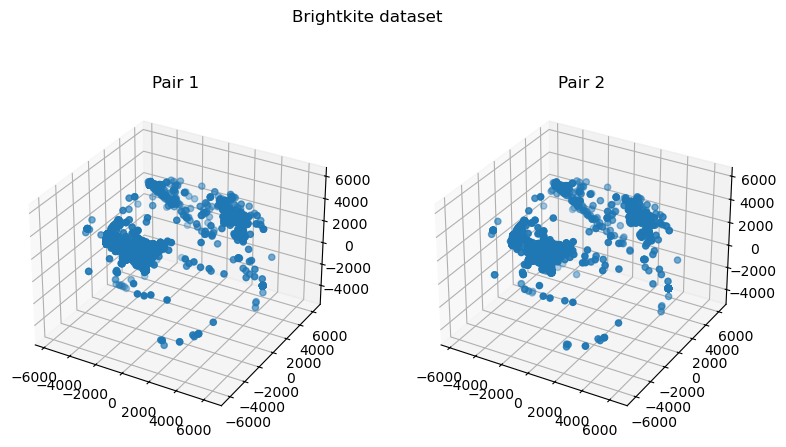

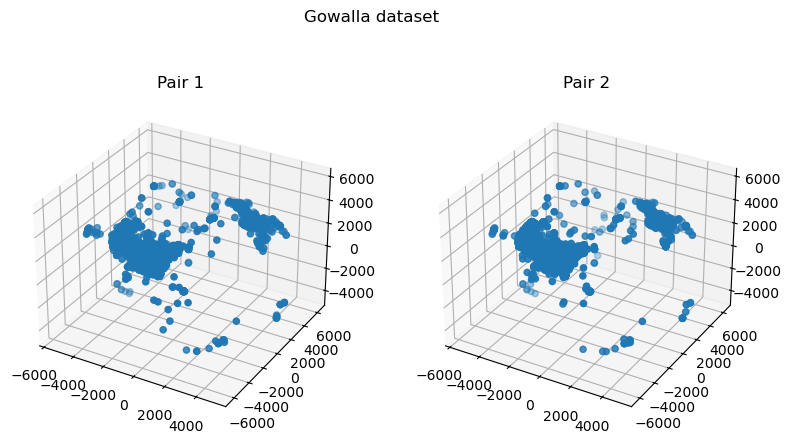

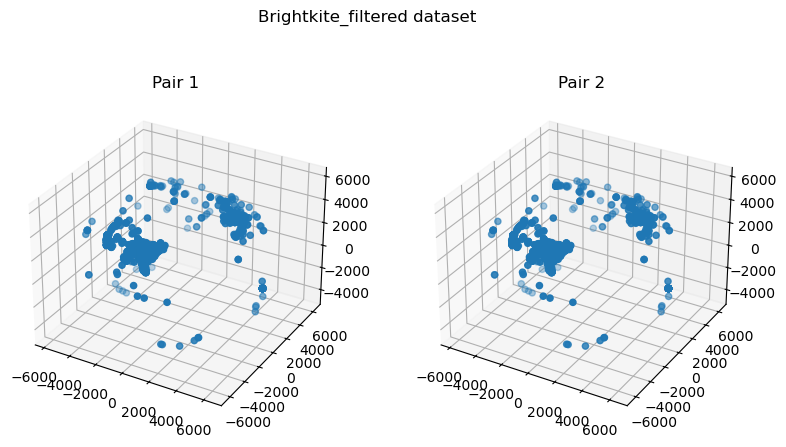

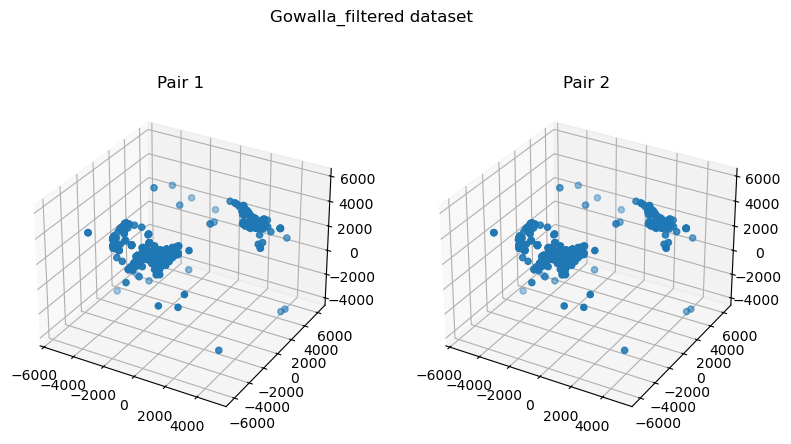

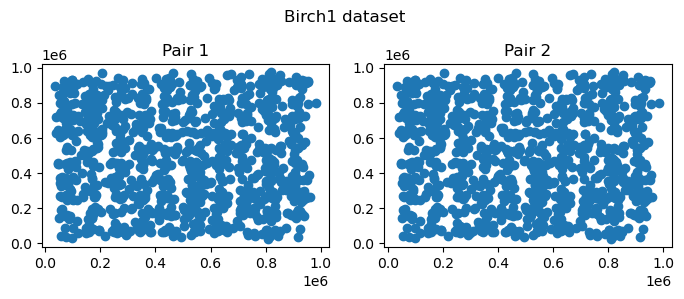

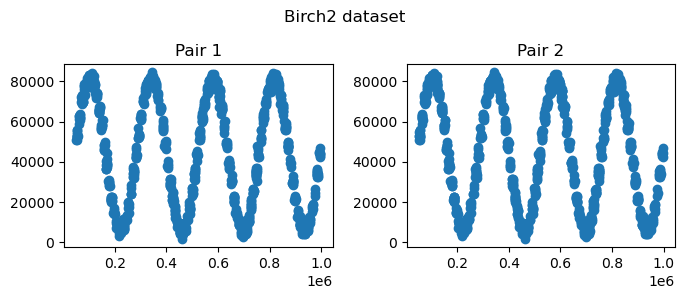

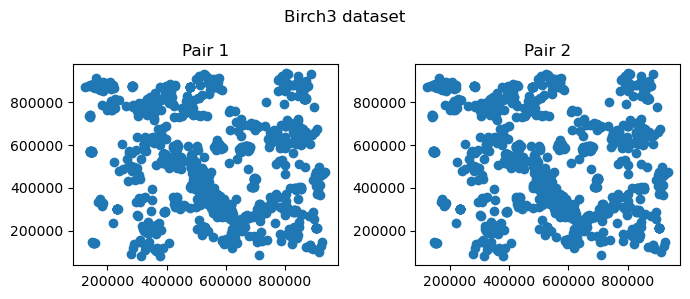

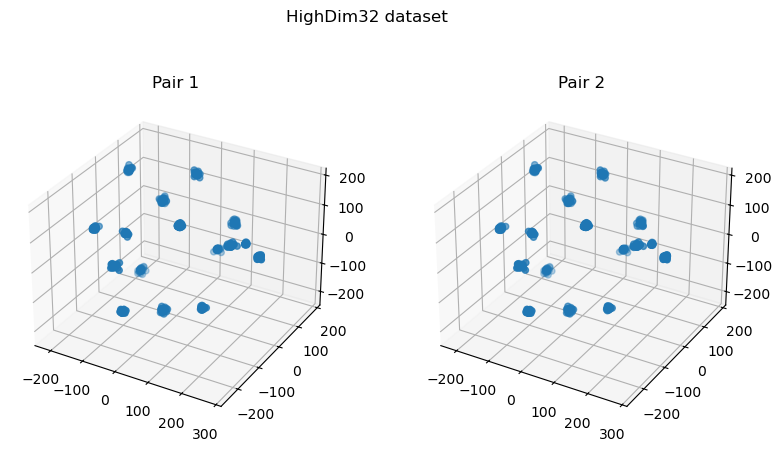

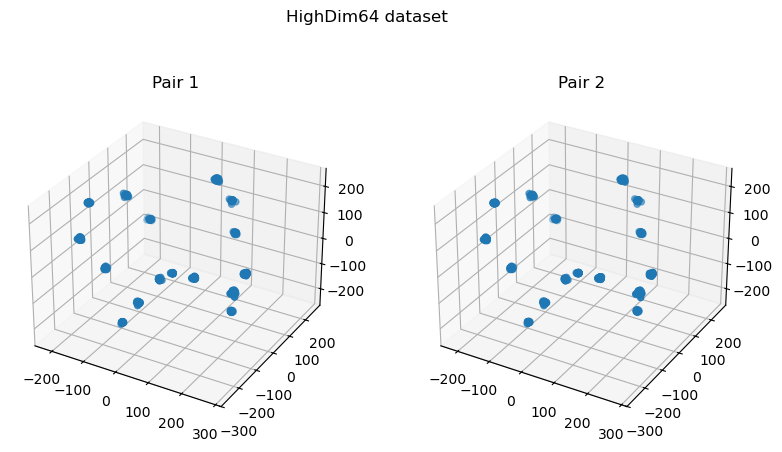

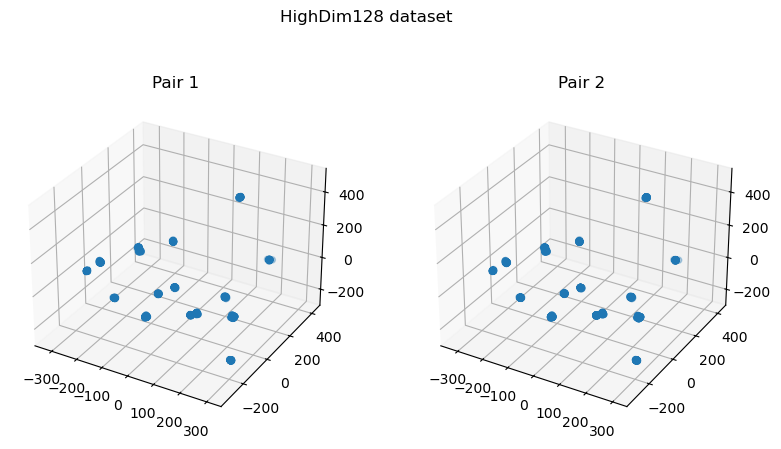

In [5]:
from src.testing.plot_helper import plot_data
from src.datasets import *
from os.path import join, isdir
from os import mkdir
ds_path = "./dataset"
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Geo(join(ds_path, "snap_standford/Brightkite_filtered_epsilon.csv"), "Brightkite_filtered", lamb=1.1, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_filtered_epsilon.csv"), "Gowalla_filtered", lamb=1.001, k=50),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10)
           ]
plot_path = "./dataset/plot"
if not isdir(plot_path):
    mkdir(plot_path)
for ds in dataset:
    pair1, pair2 = ds.load()
    plot_data(pair1, pair2, plot_path, ds.name)

## Experiment

### k-resillient

In [13]:
import numpy as np
from src.resilient_k import resilient_k_center
from src.datasets import *
from os.path import join, isdir
from os import mkdir, makedirs
from src.testing.plot_helper import plot_cluster_result
import pickle
#import time

In [14]:
def experiment(ds, resilient_k_param, plot_path, result_path):
    for algo in resilient_k_param["algorithm"]:
        for alpha in resilient_k_param["alpha"]:
            for beta in resilient_k_param["beta"]:     
                print(f"Processing {ds.name} dataset with k={ds.k}, lamb={ds.lamb}, alpha={alpha}, beta={beta}, algorithm={algo}")
                pair1, pair2 = ds.load()
                epsilon = 0.3
                seed = 1024
                model1 = resilient_k_center(pair1, k=ds.k, lamb=ds.lamb, epsilon=epsilon, alpha=alpha, beta=beta, algorithm=algo, exp=True, seed=seed)
                #start_time = time.process_time_ns()
                center1, cluster1 = model1.resilient_k_center()
                #end_time = time.process_time_ns()
                #time_taken1 = end_time - start_time
                
                model2 = resilient_k_center(pair2, k=ds.k, lamb=ds.lamb, epsilon=epsilon, alpha=alpha, beta=beta, algorithm=algo, exp=True, seed=seed)
                #start_time = time.process_time_ns()
                center2, cluster2 = model2.resilient_k_center()
                #end_time = time.process_time_ns()
                #time_taken2 = end_time - start_time
                
                this_result_path = join(result_path, ds.name)
                if not isdir(this_result_path):
                    mkdir(this_result_path)
                with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_{algo}({alpha}_{beta}).pickle"), 'wb') as output_file:
                    #pickle.dump((center1, cluster1, center2, cluster2, time_taken1, time_taken2), output_file)
                    pickle.dump((center1, cluster1, center2, cluster2), output_file)
                    
                pt1 = np.asarray([c[0] for c in cluster1])
                pt2 = np.asarray([c[0] for c in cluster2])
                label1 = [c[1] for c in cluster1]
                label2 = [c[1] for c in cluster2]
                
                this_plot_path = join(plot_path, ds.name)
                if not isdir(this_plot_path):
                    mkdir(this_plot_path)
                plot_cluster_result(pt1, pt2, label1, label2, this_plot_path, ds, algo, alpha, beta)

In [15]:
ds_path = "./dataset"
resilient_k_param ={"alpha": [0.5, 1.0], 
                    "beta": [0.5, 1.0],
                    "algorithm": ["gonz", "carv"]}

resilient_k_result_path = "./results/resilient_k_1024"
plot_path = "./results/resilient_k_1024/plot"

if not isdir(resilient_k_result_path):
    makedirs(resilient_k_result_path)
if not isdir(plot_path):
    mkdir(plot_path)

#### 1. Uber

In [16]:
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, resilient_k_result_path)

Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  14.0
Best R:  12.0
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  6.0
Best R:  5.0
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  14.0
Best R:  12.0
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  6.0
Best R:  5.0
Processing Uber dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing Uber dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Uber dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
P

#### 2. Brightkite & Gowalla

In [19]:
dataset = [Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, resilient_k_result_path)

Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  2848.0
Best R:  2611.0
Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  1796.0
Best R:  1659.0
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  2848.0
Best R:  2611.0
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  1796.0
Best R:  1659.0
Processing Brightkite dataset with k=100, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing Brightkite dataset with k=100, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz


#### 3. Birch

In [17]:
dataset = [Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=20)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, resilient_k_result_path)

Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  362284.0
Best R:  362284.0
Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  284584.0
Best R:  284583.0
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  362284.0
Best R:  362284.0
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  284584.0
Best R:  284583.0
Processing Birch1 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing Birch1 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch1 dataset 

#### 4.High dim 

In [18]:
dataset = [HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=20)]
for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, resilient_k_result_path)

Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  428.0
Best R:  427.0
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  374.0
Best R:  374.0
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  428.0
Best R:  427.0
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  374.0
Best R:  374.0
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim32

## Evalutaion

In [32]:
from src.evaluation import Metrics
from src.testing.find_pair_assignment import find_pair_assign
from os.path import join, isdir, isfile
from os import mkdir
from src.datasets import *

In [79]:
ds_path = "./dataset"
resilient_k_param ={"alpha": [0.5, 1.0], 
                    "beta": [0.5, 1.0],
                    "algorithm": ["gonz", "carv"]}

to_eval = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50), 
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=20), 
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=20) 
           ]
result_path = "./results"
baseline_path = join(result_path, "baseline")

### Baseline

#### 1. Gonz algorithm

In [ ]:
from src.evaluation import GonzalezAlgorithm

for ds in to_eval:
    print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
    pair1, pair2 = ds.load()
    model1 = GonzalezAlgorithm(pair1, ds.k)
    center1, cluster1 = model1.gonzalez()
    model1 = GonzalezAlgorithm(pair2, ds.k)
    center2, cluster2 = model1.gonzalez()
    
    this_result_path = join(baseline_path, "gonz")
    with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_gonz_only.pickle"), 'wb') as output_file:
        pickle.dump((center1, cluster1, center2, cluster2), output_file)

#### 2. Carve algorithm

In [ ]:
from src.evaluation import CarvingAlgorithm

for ds in to_eval:
    print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
    pair1, pair2 = ds.load()
    
    model1 = CarvingAlgorithm(pair1)
    best_r = model1.find_minimum_R(ds.k)
    center1, cluster1 = model1.carve(best_r, ds.k)
    model2 = CarvingAlgorithm(pair2)
    best_r = model2.find_minimum_R(ds.k)
    center2, cluster2 = model2.carve(best_r, ds.k)
    
    this_result_path = join(baseline_path, "carv")
    with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_carv_only.pickle"), 'wb') as output_file:
        pickle.dump((center1, cluster1, center2, cluster2), output_file)

#### 3. HS algorithm

In [ ]:
from src.evaluation import HSAlgorithm

for ds in to_eval:
    print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
    pair1, pair2 = ds.load()
    
    model1 = HSAlgorithm(pair1,ds.k)
    center1, cluster1 = model1.hs_algorithm(pair1, ds.k)
    model2 = HSAlgorithm(pair1,ds.k)
    center2, cluster2 = model2.hs_algorithm(pair2, ds.k)
    
    this_result_path = join(baseline_path, "hs")
    with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_hs_only.pickle"), 'wb') as output_file:
        pickle.dump((center1, cluster1, center2, cluster2), output_file)

### Result

In [1]:
from src.evaluation import Metrics
from src.testing.find_pair_assignment import find_pair_assign
from os.path import join, isdir, isfile
from os import mkdir
from src.datasets import *

In [3]:
result_base_path = "./results/"
result_name = "resilient_k_1024"
result_path = f"./results/{result_name}"
exp_seed = 5331
baseline_path = join(result_base_path, f"baseline/{exp_seed}")
eval_path = f"./results/eval/{result_name}/dennis"
ds_path = "./dataset"
if not isdir(eval_path):
    mkdir(eval_path)
to_eval = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100),
           # Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50), 
           # Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=20), 
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=20) 
           ]

In [85]:
epsilon = 0.3
for ds in to_eval: 
    if isfile(join(eval_path, f"{ds.name}_{result_name}_exp_result.csv")):
        ds_result = pd.read_csv(join(eval_path, f"{ds.name}_{result_name}_exp_result.csv"))
    else:
        ds_result = pd.DataFrame() #  columns=["k", "algo", "alpha", "beta", "fraction_changed", "sol_cost_1", "sol_cost_2", "num_cluster_1", "num_cluster_2"]
    for algo in resilient_k_param["algorithm"]:
        for alpha in resilient_k_param["alpha"]:
            for beta in resilient_k_param["beta"]:    
                this_result_path = join(result_path, ds.name, f"{ds.name}_resilient_{ds.k}_{algo}({alpha}_{beta}).pickle")
                this_eval_path = join(eval_path, ds.name)
                if not isdir(this_eval_path):
                    mkdir(this_eval_path)
                #pair1, pair2, label1, label2 = find_pair_assign(ds, this_result_path, this_eval_path)
                #print("pair1", pair1[:10], "pair2", pair2[:10], "label1", label1[:10], "label2", label2[:10], sep='\n')
                #break
                with open(this_result_path, "rb") as input_file:
                    (center1, cluster1, center2, cluster2) = pickle.load(input_file)
                #print("center1:", center1[0], "cluster1:", cluster1[0], "center2:",center2[0], "cluster2:", cluster2[0], sep='\n')
                metric = Metrics()
                #print(f"{ds.name}")
                fraction_changed, sol_cost, num_cluster = metric.evaluate(old_points=cluster1, old_medoids=center1, new_points=cluster2, new_medoids=center2, epsilon=epsilon)
                ds_result = pd.concat([ds_result, pd.DataFrame.from_records([{
                    "k": ds.k, "algo": f"{algo}({alpha}, {beta})", "fraction_changed": fraction_changed, "sol_cost_1": sol_cost[0], "sol_cost_2": sol_cost[1], "num_cluster_1": num_cluster[0], "num_cluster_2": num_cluster[1]
                }])], ignore_index=True)
    #             break
    #         break
    #     break
    # break

    ds_result.to_csv(join(eval_path, f"{ds.name}_{result_name}_exp_result.csv"), index=False)

In [88]:
baselines = ['gonz', 'carve', 'hs']
epsilon = 0.3
for ds in to_eval:
    if isfile(join(eval_path, f"{ds.name}_baseline_exp_result.csv")):
        ds_result = pd.read_csv(join(eval_path, f"{ds.name}_baseline_exp_result.csv"))
    else:
        ds_result = pd.DataFrame() #  columns=["k", "algo", "fraction_changed", "sol_cost_1", "sol_cost_2", "num_cluster_1", "num_cluster_2"]
    for baseline in baselines:
        this_result_path = join(baseline_path, f"{ds.name}_resilient_{ds.k}_{baseline}_only.pickle")
        this_eval_path = join(eval_path, ds.name)
        with open(this_result_path, "rb") as input_file:
                    (center1, cluster1, center2, cluster2) = pickle.load(input_file)
        #print("center1:", center1, "cluster1:", cluster1, "center2:",center2, "cluster2:", cluster2, sep='\n')
        #pair1, pair2, label1, label2 = find_pair_assign(ds, this_result_path, this_eval_path)
        metric = Metrics()
        fraction_changed, sol_cost, num_cluster = metric.evaluate(old_points=cluster1, old_medoids=center1, new_points=cluster2, new_medoids=center2, epsilon=epsilon)
        ds_result = pd.concat([ds_result, pd.DataFrame.from_records([{
            "k": ds.k, "algo": baseline, "fraction_changed": fraction_changed, "sol_cost_1": sol_cost[0], "sol_cost_2": sol_cost[1], "num_cluster_1": num_cluster[0], "num_cluster_2": num_cluster[1]
        }])], ignore_index=True)
    ds_result.to_csv(join(eval_path, f"{ds.name}_baseline_exp_result.csv"), index=False)

keys: dict_keys([10, 20])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


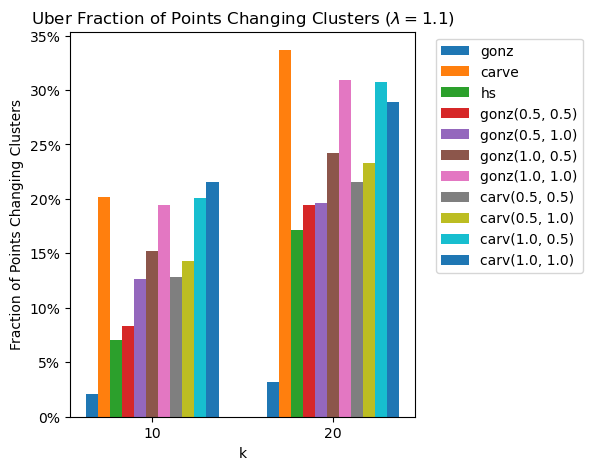

keys: dict_keys([50, 100])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


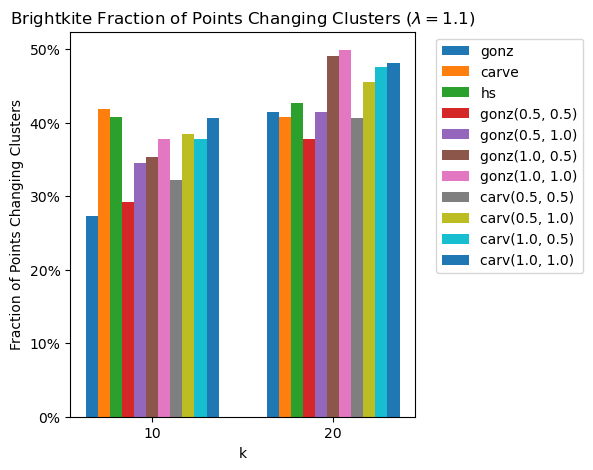

keys: dict_keys([10, 20])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


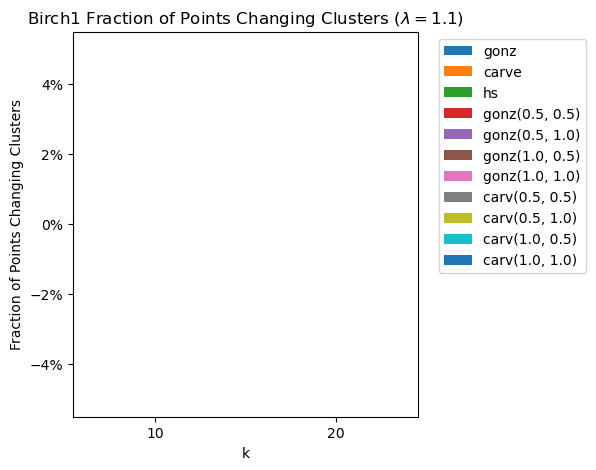

keys: dict_keys([10, 20])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


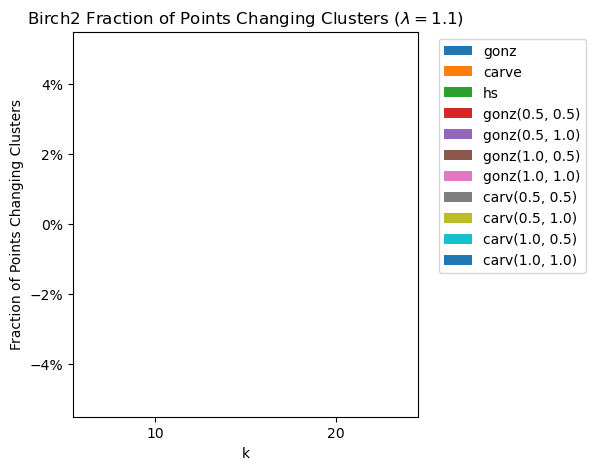

keys: dict_keys([10, 20])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


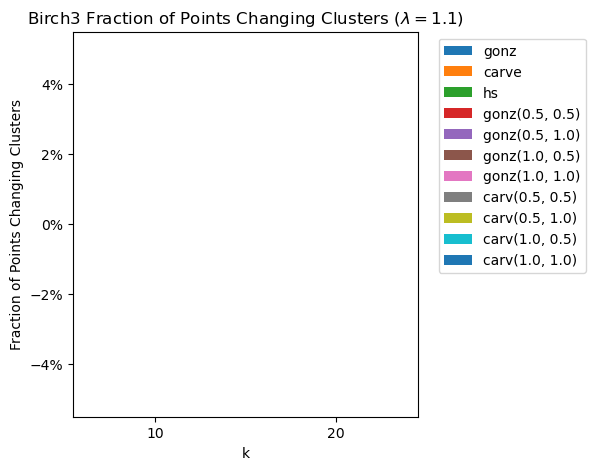

keys: dict_keys([10, 20])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


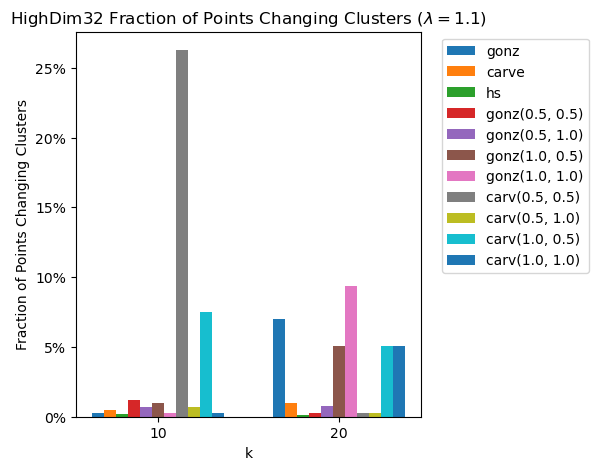

keys: dict_keys([10, 20])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


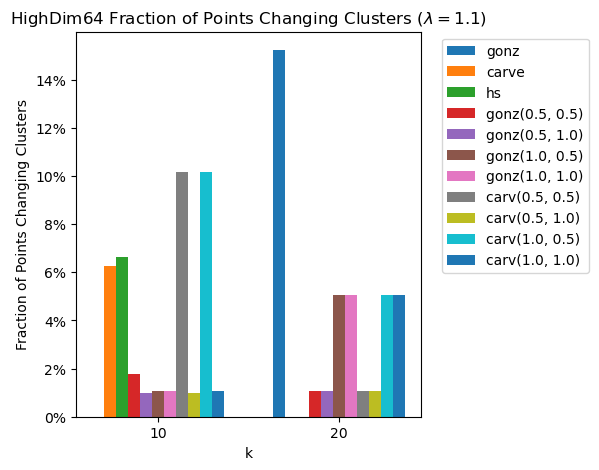

keys: dict_keys([10, 20])


D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bars.append(ax.bar(i * margin + width * j, grp['fraction_changed'][j], width, label=algo))


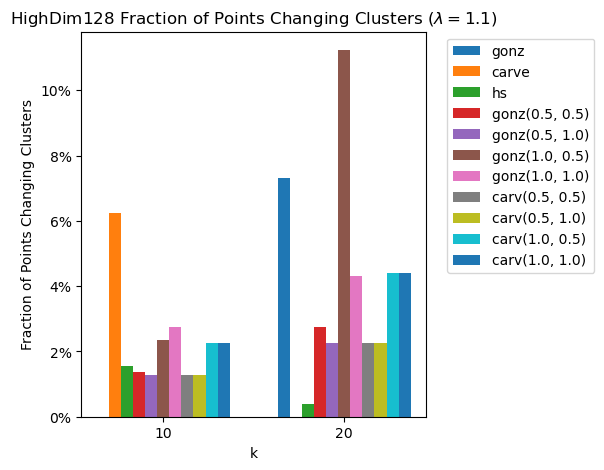

In [23]:
from src.testing.plot_helper import plot_result_bar
lamb = 1.1
to_plot = {"Uber": lamb, "Brightkite": lamb, "Birch1": lamb, "Birch2": lamb, "Birch3": lamb, "HighDim32": lamb, "HighDim64": lamb, "HighDim128": lamb}
eval_path = "results/eval"
result_name = "resilient_k_1024"
eval_path = f"./results/eval/{result_name}/dennis"
plot_path = (f"{eval_path}/plot")
if not isdir(plot_path):
    mkdir(plot_path)
for ds, lamb in to_plot.items():
    resilient_k_df = pd.read_csv(join(eval_path, f"{ds}_{result_name}_exp_result.csv"))
    baseline_df = pd.read_csv(join(eval_path, f"{ds}_baseline_exp_result.csv")) 
    #baseline_df = pd.DataFrame()
    plot_result_bar(resilient_k_df, baseline_df, ds, lamb, plot_path)